In [ ]:
# Laurent LEQUIEVRE
# Research Engineer, CNRS (France)
# Institut Pascal UMR6602
# laurent.lequievre@uca.fr

# based on : https://github.com/markusbuchholz/deep-reinforcement-learning/blob/master/dqn/solution/dqn_agent.py

In [1]:
import numpy as np
import random 
from collections import namedtuple, deque 
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

import gym
from gym.envs.registration import register

In [2]:
class ReplayBuffer:
    """Fixed -size buffe to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experiences = namedtuple("Experience", field_names=["state",
                                                               "action",
                                                               "reward",
                                                               "next_state",
                                                               "done"])
        
    def add(self,state, action, reward, next_state,done):
        """Add a new experience to memory."""
        e = self.experiences(state,action,reward,next_state,done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory"""
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
        
        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [3]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.observation_space_size = state_size
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

env = gym.make('CartPole-v1')


class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            
        """
        self.state_size = state_size
        self.action_size = action_size
        

        # Q-Network
        self.qnetwork_local = QNetwork(self.state_size, self.action_size)
        self.qnetwork_target = QNetwork(self.state_size, self.action_size)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(self.action_size, BUFFER_SIZE, BATCH_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

        
    def choose_action(self, s):
        s = torch.from_numpy(s).float().unsqueeze(0)
        
        if (np.random.rand(1) < 0.1): 
            #print("sample action !")
            #return self.env.action_space.sample()
            return random.choice(np.arange(self.action_size))
        else:
            #agent_out = self.qnetwork_local(s).detach()
            
            self.qnetwork_local.eval()  #puts network in evaluation mode
            with torch.no_grad():
                agent_out = self.qnetwork_local(s)
            self.qnetwork_local.train()  #puts network back in training mode
            
            
            
            #print(agent_out)
            index_max = np.argmax(agent_out)
            #print("index max = {}".format(index_max))
            #print("torch max action !")
            return index_max.item()    
        
        
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
   

agent = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.n)

Episode 100	Average Score: 10.11
Episode 200	Average Score: 9.722
Episode 300	Average Score: 9.883
Episode 400	Average Score: 10.13
Episode 500	Average Score: 10.79
Episode 600	Average Score: 10.44
Episode 700	Average Score: 10.43
Episode 800	Average Score: 10.06
Episode 900	Average Score: 10.53
Episode 1000	Average Score: 10.64
Episode 1100	Average Score: 11.25
Episode 1200	Average Score: 11.10
Episode 1300	Average Score: 11.96
Episode 1400	Average Score: 57.80
Episode 1500	Average Score: 161.21
Episode 1584	Average Score: 200.08
Environment solved in 1484 episodes!	Average Score: 200.08


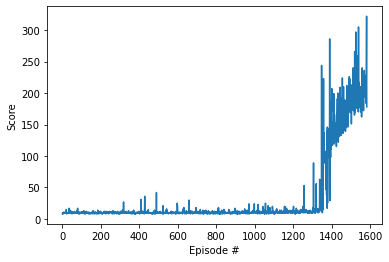

In [5]:
import matplotlib.pyplot as plt


def dqn(n_episodes=2000, max_t=1000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    #eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        #eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [6]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    print("i = {}".format(i))
    state = env.reset()
    done = False

    while not done:
            state = torch.from_numpy(state).float().unsqueeze(0)
            agent_out = agent.qnetwork_local(state).detach()
            index_max = np.argmax(agent_out)
            action =  index_max.item()    
            env.render()
            state, reward, done, _ = env.step(action)

    env.render()
env.close()


i = 0
i = 1
i = 2
